In [2]:
import os
import numpy as np
# import tensorflow.keras.utils as image
from tensorflow.keras.utils import load_img, img_to_array
import cv2

import dlib
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# basedir = Path('./Datasets')
# celeba_images_dir = (basedir / 'celeba' / 'img')

In [4]:
global basedir, image_paths, target_size
basedir = '.\Datasets'
celeba_images_dir_train = os.path.join(basedir,'celeba')
celeba_images_dir_test = os.path.join(basedir,'celeba_test')
final_image_dir_train = os.path.join(celeba_images_dir_train,'img')
final_image_dir_test = os.path.join(celeba_images_dir_test,'img')
labels_filename = 'labels.csv'


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [5]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [6]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [7]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image


In [8]:
def extract_features_labels(final_image_dir, celeba_images_dir, labels_filename):
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extract the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(final_image_dir, l) for l in os.listdir(final_image_dir)]
    target_size = None
    labels_file = open(os.path.join(celeba_images_dir, labels_filename), 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split()[1] : int(line.split()[3]) for line in lines[1:]}
    if os.path.isdir(celeba_images_dir):
        all_features = []
        all_labels = []
        for img_path in image_paths:
            file_name = img_path.split('.')[1].split('\\')[-1]
            label_file_name = file_name + '.jpg'

            # load image
            img = img_to_array(
                load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[label_file_name])

    landmark_features = np.array(all_features)
    gender_labels = (np.array(all_labels) + 1)/2 # simply converts the -1 into 0, so male=0 and female=1
    return landmark_features, gender_labels


In [9]:
X, y = extract_features_labels(final_image_dir = final_image_dir_train, celeba_images_dir = celeba_images_dir_train, labels_filename = labels_filename )
X_test, y_test = extract_features_labels(final_image_dir = final_image_dir_test, celeba_images_dir = celeba_images_dir_test, labels_filename = labels_filename )
Y_test = np.array([y_test, -(y_test - 1)]).T
Y = np.array([y, -(y - 1)]).T
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)
# In this case, the test_size parameter is equal to 0.2, so that our validation set will
# have 20% of the data, while the training set will have the remaining 80% of the data
input_shape = X_train.shape

In [10]:
input_shape[1:]

(68, 2)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
import datetime as dt

In [13]:
# num_classes = 2
# model = Sequential()
# # Add the input layer and flatten the input
# model.add(Flatten(input_shape = ( 68, 2)))
# # Add the first hidden layer
# model.add(Dense(units=128,activation='relu'))
# # Add the second hidden layer
# model.add(Dense(units=64,activation='relu'))
# # Add the output layer
# model.add(Dense(units=2, activation='sigmoid'))

In [14]:
def create_MLP_model(optimizer='Adam', learning_rate=0.001, amsgrad=False):

    num_classes = 2
    model = Sequential()
    # Add the input layer and flatten the input
    model.add(Flatten(input_shape = (68, 2)))
    # Add the first hidden layer
    model.add(Dense(units=128,activation='relu'))
    # Add the second hidden layer
    model.add(Dense(units=64,activation='relu'))
    # Add the output layer
    model.add(Dense(units=num_classes, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate, amsgrad=amsgrad )
    # Compile model (sparse cross-entropy can be used if one hot encoding not used)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[keras.metrics.mae, keras.metrics.categorical_accuracy])

    return model

In [15]:
model = create_MLP_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 136)               0         
                                                                 
 dense (Dense)               (None, 128)               17536     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 25,922
Trainable params: 25,922
Non-trainable params: 0
_________________________________________________________________


In [16]:
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)



# Start the training and save its progress in a variable called 'history'
history = model.fit(train_dataset, validation_data=(X_valid, Y_valid), epochs=250)



Epoch 1/250
60/60 [==============================] - 2s 15ms/step - loss: 5.3389 - mean_absolute_error: 0.5000 - categorical_accuracy: 0.5070 - val_loss: 2.1418 - val_mean_absolute_error: 0.5000 - val_categorical_accuracy: 0.5292
Epoch 2/250
60/60 [==============================] - 1s 9ms/step - loss: 1.1600 - mean_absolute_error: 0.5000 - categorical_accuracy: 0.5070 - val_loss: 3.1141 - val_mean_absolute_error: 0.5000 - val_categorical_accuracy: 0.5292
Epoch 3/250
60/60 [==============================] - 1s 12ms/step - loss: 4.1973 - mean_absolute_error: 0.5000 - categorical_accuracy: 0.5070 - val_loss: 1.8949 - val_mean_absolute_error: 0.5000 - val_categorical_accuracy: 0.5292
Epoch 4/250
60/60 [==============================] - 1s 10ms/step - loss: 3.7376 - mean_absolute_error: 0.5000 - categorical_accuracy: 0.5070 - val_loss: 0.6293 - val_mean_absolute_error: 0.5000 - val_categorical_accuracy: 0.5292
Epoch 5/250
60/60 [==============================] - 1s 15ms/step - loss: 0.8087 

In [17]:
import matplotlib.pyplot as plt

In [18]:
results = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print("test loss, MAE, test acc:", results)

16/16 [==============================] - 0s 4ms/step - loss: 0.2707 - mean_absolute_error: 0.3179 - categorical_accuracy: 0.8845
test loss, MAE, test acc: [0.2706507742404938, 0.3179129660129547, 0.88453608751297]


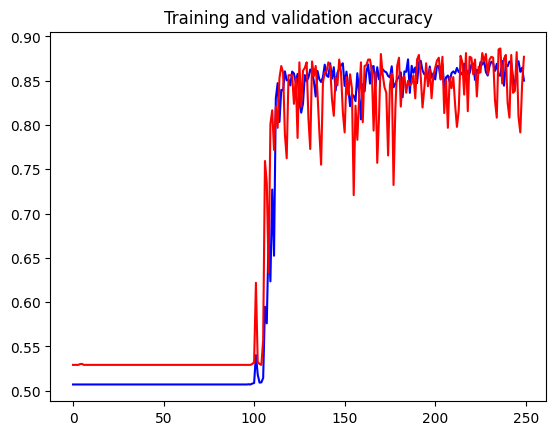

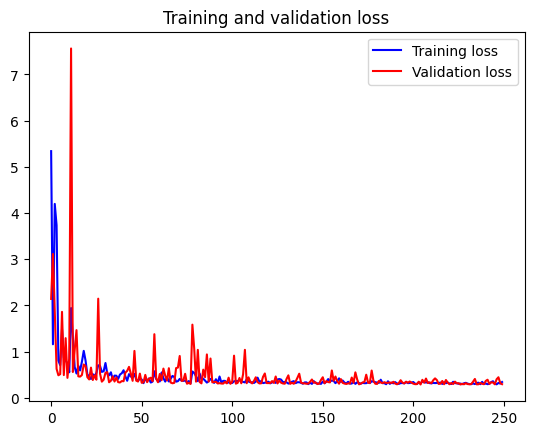

In [19]:
accuracy = history.history["categorical_accuracy"]
val_accuracy = history.history["val_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(accuracy))

plt.figure(1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend
plt.savefig('Training and validation accuracy.png')

plt.figure(2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig('Training and validation loss.png')

In [20]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, accuracy_score

In [21]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

16/16 [==============================] - 0s 2ms/step
Confusion matrix:
[[ 40 433]
 [425  72]]


<Figure size 640x480 with 0 Axes>

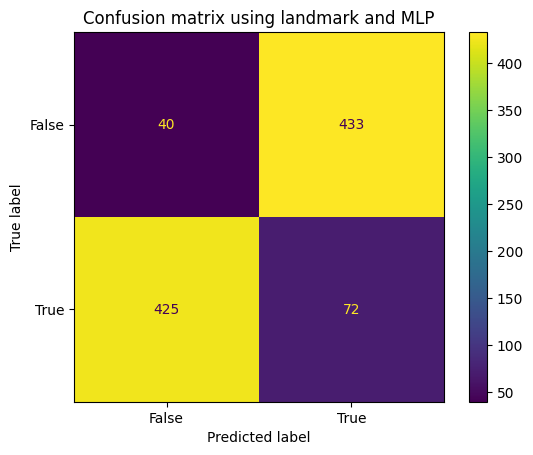

In [22]:
predictions = model.predict(X_test, batch_size=BATCH_SIZE)
predictions_sparse = []

for one_hot_pred in predictions:
    if one_hot_pred[0] > one_hot_pred[1]:
        predictions_sparse.append(0)
    else:
        predictions_sparse.append(1)
cm = metrics.confusion_matrix(y_test, predictions_sparse)
print("Confusion matrix:\n%s" % cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
plt.figure(3)
cm_display.plot()
plt.title("Confusion matrix using landmark and MLP")
plt.savefig('Confusion matrix using landmark and MLP')



In [28]:
def batch_epoch_hyper(n_folds):
    '''
    This function finds the best hyperparameters among those given by the user for batch size and epoch size
    '''

    print('hyperparameterization: batch_size and epochs')
    # create model
    model = KerasClassifier(build_fn=create_MLP_model, verbose=0)

    # define the grid search parameters
    batch_size = [32, 64, 128]
    epochs = [10, 15, 20]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=n_folds, n_jobs=4)
    grid_result = grid.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))
    # summarize results
    print("Best: using %s" % (grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, stdev, param))

In [29]:
batch_epoch_hyper(n_folds = 8)

hyperparameterization: batch_size and epochs


c:\Users\sen\anaconda3\envs\Yusen\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  
c:\Users\sen\anaconda3\envs\Yusen\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


Best: using {'batch_size': 32, 'epochs': 10}


In [25]:
# import itertools

# import tensorflow as tf
# from tensorflow.keras import layers, Model, Input


# CONV_KERNEL_INITIALIZER = {
#     'class_name': 'VarianceScaling',
#     'config': {
#         'scale': 2.0,
#         'mode': 'fan_out',
#         'distribution': 'truncated_normal'
#     }
# }

# DENSE_KERNEL_INITIALIZER = {
#     'class_name': 'VarianceScaling',
#     'config': {
#         'scale': 1. / 3.,
#         'mode': 'fan_out',
#         'distribution': 'uniform'
#     }
# }


# class SE(layers.Layer):
#     def __init__(self,
#                  se_filters: int,
#                  output_filters: int,
#                  name: str = None):
#         super(SE, self).__init__(name=name)

#         self.se_reduce = layers.Conv2D(filters=se_filters,
#                                        kernel_size=1,
#                                        strides=1,
#                                        padding="same",
#                                        activation="swish",
#                                        use_bias=True,
#                                        kernel_initializer=CONV_KERNEL_INITIALIZER,
#                                        name="conv2d")

#         self.se_expand = layers.Conv2D(filters=output_filters,
#                                        kernel_size=1,
#                                        strides=1,
#                                        padding="same",
#                                        activation="sigmoid",
#                                        use_bias=True,
#                                        kernel_initializer=CONV_KERNEL_INITIALIZER,
#                                        name="conv2d_1")

#     def call(self, inputs, **kwargs):
#         # Tensor: [N, H, W, C] -> [N, 1, 1, C]
#         se_tensor = tf.reduce_mean(inputs, [1, 2], keepdims=True)
#         se_tensor = self.se_reduce(se_tensor)
#         se_tensor = self.se_expand(se_tensor)
#         return se_tensor * inputs


# class MBConv(layers.Layer):
#     def __init__(self,
#                  kernel_size: int,
#                  input_c: int,
#                  out_c: int,
#                  expand_ratio: int,
#                  stride: int,
#                  se_ratio: float = 0.25,
#                  drop_rate: float = 0.,
#                  name: str = None):
#         super(MBConv, self).__init__(name=name)

#         if stride not in [1, 2]:
#             raise ValueError("illegal stride value.")

#         self.has_shortcut = (stride == 1 and input_c == out_c)
#         expanded_c = input_c * expand_ratio

#         bid = itertools.count(0)
#         get_norm_name = lambda: 'batch_normalization' + ('' if not next(
#             bid) else '_' + str(next(bid) // 2))
#         cid = itertools.count(0)
#         get_conv_name = lambda: 'conv2d' + ('' if not next(cid) else '_' + str(
#             next(cid) // 2))

#         # 在EfficientNetV2中，MBConv中不存在expansion=1的情况所以conv_pw肯定存在
#         assert expand_ratio != 1
#         # Point-wise expansion
#         self.expand_conv = layers.Conv2D(
#             filters=expanded_c,
#             kernel_size=1,
#             strides=1,
#             padding="same",
#             use_bias=False,
#             name=get_conv_name())
#         self.norm0 = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name=get_norm_name())
#         self.act0 = layers.Activation("swish")

#         # Depth-wise convolution
#         self.depthwise_conv = layers.DepthwiseConv2D(
#             kernel_size=kernel_size,
#             strides=stride,
#             depthwise_initializer=CONV_KERNEL_INITIALIZER,
#             padding="same",
#             use_bias=False,
#             name="depthwise_conv2d")
#         self.norm1 = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name=get_norm_name())
#         self.act1 = layers.Activation("swish")

#         # SE
#         num_reduced_filters = max(1, int(input_c * se_ratio))
#         self.se = SE(num_reduced_filters, expanded_c, name="se")

#         # Point-wise linear projection
#         self.project_conv = layers.Conv2D(
#             filters=out_c,
#             kernel_size=1,
#             strides=1,
#             kernel_initializer=CONV_KERNEL_INITIALIZER,
#             padding="same",
#             use_bias=False,
#             name=get_conv_name())
#         self.norm2 = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name=get_norm_name())

#         self.drop_rate = drop_rate
#         if self.has_shortcut and drop_rate > 0:
#             # Stochastic Depth
#             self.drop_path = layers.Dropout(rate=drop_rate,
#                                             noise_shape=(None, 1, 1, 1),  # binary dropout mask
#                                             name="drop_path")

#     def call(self, inputs, training=None):
#         x = inputs

#         x = self.expand_conv(x)
#         x = self.norm0(x, training=training)
#         x = self.act0(x)

#         x = self.depthwise_conv(x)
#         x = self.norm1(x, training=training)
#         x = self.act1(x)

#         x = self.se(x)

#         x = self.project_conv(x)
#         x = self.norm2(x, training=training)

#         if self.has_shortcut:
#             if self.drop_rate > 0:
#                 x = self.drop_path(x, training=training)

#             x = tf.add(x, inputs)

#         return x


# class FusedMBConv(layers.Layer):
#     def __init__(self,
#                  kernel_size: int,
#                  input_c: int,
#                  out_c: int,
#                  expand_ratio: int,
#                  stride: int,
#                  se_ratio: float,
#                  drop_rate: float = 0.,
#                  name: str = None):
#         super(FusedMBConv, self).__init__(name=name)
#         if stride not in [1, 2]:
#             raise ValueError("illegal stride value.")

#         assert se_ratio == 0.

#         self.has_shortcut = (stride == 1 and input_c == out_c)
#         self.has_expansion = expand_ratio != 1
#         expanded_c = input_c * expand_ratio

#         bid = itertools.count(0)
#         get_norm_name = lambda: 'batch_normalization' + ('' if not next(
#             bid) else '_' + str(next(bid) // 2))
#         cid = itertools.count(0)
#         get_conv_name = lambda: 'conv2d' + ('' if not next(cid) else '_' + str(
#             next(cid) // 2))

#         if expand_ratio != 1:
#             self.expand_conv = layers.Conv2D(
#                 filters=expanded_c,
#                 kernel_size=kernel_size,
#                 strides=stride,
#                 kernel_initializer=CONV_KERNEL_INITIALIZER,
#                 padding="same",
#                 use_bias=False,
#                 name=get_conv_name())
#             self.norm0 = layers.BatchNormalization(
#                 axis=-1,
#                 momentum=0.9,
#                 epsilon=1e-3,
#                 name=get_norm_name())
#             self.act0 = layers.Activation("swish")

#         self.project_conv = layers.Conv2D(
#             filters=out_c,
#             kernel_size=1 if expand_ratio != 1 else kernel_size,
#             strides=1 if expand_ratio != 1 else stride,
#             kernel_initializer=CONV_KERNEL_INITIALIZER,
#             padding="same",
#             use_bias=False,
#             name=get_conv_name())
#         self.norm1 = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name=get_norm_name())

#         if expand_ratio == 1:
#             self.act1 = layers.Activation("swish")

#         self.drop_rate = drop_rate
#         if self.has_shortcut and drop_rate > 0:
#             # Stochastic Depth
#             self.drop_path = layers.Dropout(rate=drop_rate,
#                                             noise_shape=(None, 1, 1, 1),  # binary dropout mask
#                                             name="drop_path")

#     def call(self, inputs, training=None):
#         x = inputs
#         if self.has_expansion:
#             x = self.expand_conv(x)
#             x = self.norm0(x, training=training)
#             x = self.act0(x)

#         x = self.project_conv(x)
#         x = self.norm1(x, training=training)
#         if self.has_expansion is False:
#             x = self.act1(x)

#         if self.has_shortcut:
#             if self.drop_rate > 0:
#                 x = self.drop_path(x, training=training)

#             x = tf.add(x, inputs)

#         return x


# class Stem(layers.Layer):
#     def __init__(self, filters: int, name: str = None):
#         super(Stem, self).__init__(name=name)
#         self.conv_stem = layers.Conv2D(
#             filters=filters,
#             kernel_size=3,
#             strides=2,
#             kernel_initializer=CONV_KERNEL_INITIALIZER,
#             padding="same",
#             use_bias=False,
#             name="conv2d")
#         self.norm = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name="batch_normalization")
#         self.act = layers.Activation("swish")

#     def call(self, inputs, training=None):
#         x = self.conv_stem(inputs)
#         x = self.norm(x, training=training)
#         x = self.act(x)

#         return x


# class Head(layers.Layer):
#     def __init__(self,
#                  filters: int = 1280,
#                  num_classes: int = 1000,
#                  drop_rate: float = 0.,
#                  name: str = None):
#         super(Head, self).__init__(name=name)
#         self.conv_head = layers.Conv2D(
#             filters=filters,
#             kernel_size=1,
#             kernel_initializer=CONV_KERNEL_INITIALIZER,
#             padding="same",
#             use_bias=False,
#             name="conv2d")
#         self.norm = layers.BatchNormalization(
#             axis=-1,
#             momentum=0.9,
#             epsilon=1e-3,
#             name="batch_normalization")
#         self.act = layers.Activation("swish")

#         self.avg = layers.GlobalAveragePooling2D()
#         self.fc = layers.Dense(num_classes,
#                                kernel_initializer=DENSE_KERNEL_INITIALIZER)

#         if drop_rate > 0:
#             self.dropout = layers.Dropout(drop_rate)

#     def call(self, inputs, training=None):
#         x = self.conv_head(inputs)
#         x = self.norm(x)
#         x = self.act(x)
#         x = self.avg(x)

#         if self.dropout:
#             x = self.dropout(x, training=training)

#         x = self.fc(x)
#         return x


# class EfficientNetV2(Model):
#     def __init__(self,
#                  model_cnf: list,
#                  num_classes: int = 1000,
#                  num_features: int = 1280,
#                  dropout_rate: float = 0.2,
#                  drop_connect_rate: float = 0.2,
#                  name: str = None):
#         super(EfficientNetV2, self).__init__(name=name)

#         for cnf in model_cnf:
#             assert len(cnf) == 8

#         stem_filter_num = model_cnf[0][4]
#         self.stem = Stem(stem_filter_num)

#         total_blocks = sum([i[0] for i in model_cnf])
#         block_id = 0
#         self.blocks = []
#         # Builds blocks.
#         for cnf in model_cnf:
#             repeats = cnf[0]
#             op = FusedMBConv if cnf[-2] == 0 else MBConv
#             for i in range(repeats):
#                 self.blocks.append(op(kernel_size=cnf[1],
#                                       input_c=cnf[4] if i == 0 else cnf[5],
#                                       out_c=cnf[5],
#                                       expand_ratio=cnf[3],
#                                       stride=cnf[2] if i == 0 else 1,
#                                       se_ratio=cnf[-1],
#                                       drop_rate=drop_connect_rate * block_id / total_blocks,
#                                       name="blocks_{}".format(block_id)))
#                 block_id += 1

#         self.head = Head(num_features, num_classes, dropout_rate)

#     # def summary(self, input_shape=(224, 224, 3), **kwargs):
#     #     x = Input(shape=input_shape)
#     #     model = Model(inputs=[x], outputs=self.call(x, training=True))
#     #     return model.summary()

#     def call(self, inputs, training=None):
#         x = self.stem(inputs, training)

#         # call for blocks.
#         for _, block in enumerate(self.blocks):
#             x = block(x, training=training)

#         x = self.head(x, training=training)

#         return x


# def efficientnetv2_s(num_classes: int = 1000):
#     """
#     EfficientNetV2
#     https://arxiv.org/abs/2104.00298
#     """
#     # train_size: 300, eval_size: 384

#     # repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio
#     model_config = [[2, 3, 1, 1, 24, 24, 0, 0],
#                     [4, 3, 2, 4, 24, 48, 0, 0],
#                     [4, 3, 2, 4, 48, 64, 0, 0],
#                     [6, 3, 2, 4, 64, 128, 1, 0.25],
#                     [9, 3, 1, 6, 128, 160, 1, 0.25],
#                     [15, 3, 2, 6, 160, 256, 1, 0.25]]

#     model = EfficientNetV2(model_cnf=model_config,
#                            num_classes=num_classes,
#                            dropout_rate=0.2,
#                            name="efficientnetv2-s")
#     return model


# def efficientnetv2_m(num_classes: int = 1000):
#     """
#     EfficientNetV2
#     https://arxiv.org/abs/2104.00298
#     """
#     # train_size: 384, eval_size: 480

#     # repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio
#     model_config = [[3, 3, 1, 1, 24, 24, 0, 0],
#                     [5, 3, 2, 4, 24, 48, 0, 0],
#                     [5, 3, 2, 4, 48, 80, 0, 0],
#                     [7, 3, 2, 4, 80, 160, 1, 0.25],
#                     [14, 3, 1, 6, 160, 176, 1, 0.25],
#                     [18, 3, 2, 6, 176, 304, 1, 0.25],
#                     [5, 3, 1, 6, 304, 512, 1, 0.25]]

#     model = EfficientNetV2(model_cnf=model_config,
#                            num_classes=num_classes,
#                            dropout_rate=0.3,
#                            name="efficientnetv2-m")
#     return model


# def efficientnetv2_l(num_classes: int = 1000):
#     """
#     EfficientNetV2
#     https://arxiv.org/abs/2104.00298
#     """
#     # train_size: 384, eval_size: 480

#     # repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio
#     model_config = [[4, 3, 1, 1, 32, 32, 0, 0],
#                     [7, 3, 2, 4, 32, 64, 0, 0],
#                     [7, 3, 2, 4, 64, 96, 0, 0],
#                     [10, 3, 2, 4, 96, 192, 1, 0.25],
#                     [19, 3, 1, 6, 192, 224, 1, 0.25],
#                     [25, 3, 2, 6, 224, 384, 1, 0.25],
#                     [7, 3, 1, 6, 384, 640, 1, 0.25]]

#     model = EfficientNetV2(model_cnf=model_config,
#                            num_classes=num_classes,
#                            dropout_rate=0.4,
#                            name="efficientnetv2-l")
#     return model


# # m = efficientnetv2_s()
# # m.summary()